In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from matplotlib.colors import ListedColormap

import warnings

warnings.filterwarnings('ignore')

In [2]:
classification_data, classification_labels = datasets.make_classification(
    n_features = 2, 
    n_informative = 2, 
    n_classes = 2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    random_state=5
)

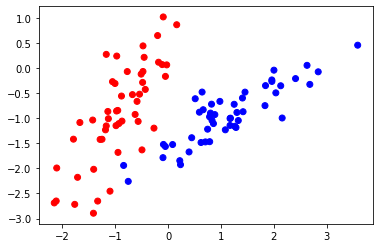

In [3]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(6,4))
plt.scatter(
    list(map(lambda x: x[0], classification_data)), 
    list(map(lambda x: x[1], classification_data)), 
    c=classification_labels, 
    cmap=colors
)

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [7]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, objects):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = objects

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

1. В коде из методички реализуйте один или несколько из критериев останова <br>
(количество листьев,<br>
количество используемых признаков,<br>
глубина дерева и т.д.).

In [10]:
# Построение дерева с помощью рекурсивной функции

def build_tree(
    data, labels,
    max_tree_size=0, ### <- 1. добавляем лимит РАЗМЕРа ДЕРЕВА
    tree_size=0, ### <- 1. добавляем РАЗМЕР ДЕРЕВА (по умолчанию не ограничено)
    min_objects=5
):
    
    quality, t, index = find_best_split(data, labels, objects=min_objects)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    if tree_size == max_tree_size: ### <- 1. сравниваем РАЗМЕР ДЕРЕВА и лимит размера
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    
    tree_size += 1 ### <- 1. увеличиваем РАЗМЕР ДЕРЕВА после каждой итерации функции на +1
    
    # Рекурсивно строим два поддерева
    true_branch = build_tree(
        true_data, true_labels, 
        max_tree_size=max_tree_size, tree_size=tree_size, ### <- 1. запуливаем РАЗМЕР ДЕРЕВА в агументы рекурсии
        min_objects=min_objects
    )
    
    false_branch = build_tree(
        false_data, false_labels, 
        max_tree_size=max_tree_size, tree_size=tree_size, ### <- 1. запуливаем РАЗМЕР ДЕРЕВА в агументы рекурсии
        min_objects=min_objects
    )
        
    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(
    classification_data, 
    classification_labels, 
    test_size = 0.3,
    random_state = 1
)

In [14]:
# Построим дерево по обучающей выборке
my_tree = build_tree(
    train_data, 
    train_labels, 
    max_tree_size=2, ### <- 1. задаем РАЗМЕР ДЕРЕВА для проверки
    min_objects=5 ### <- 1. минимальное ЧИСЛО ОБЪЕКТОВ уже было реализовано, поэтому просто выводим его в аргумент для удобства
)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

Просмотрим результат

In [16]:
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Прогноз: 0
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [17]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [18]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [19]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [20]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [21]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

Просмотрим результат на __графике__

Text(0.5, 1.0, 'Test accuracy=96.67')

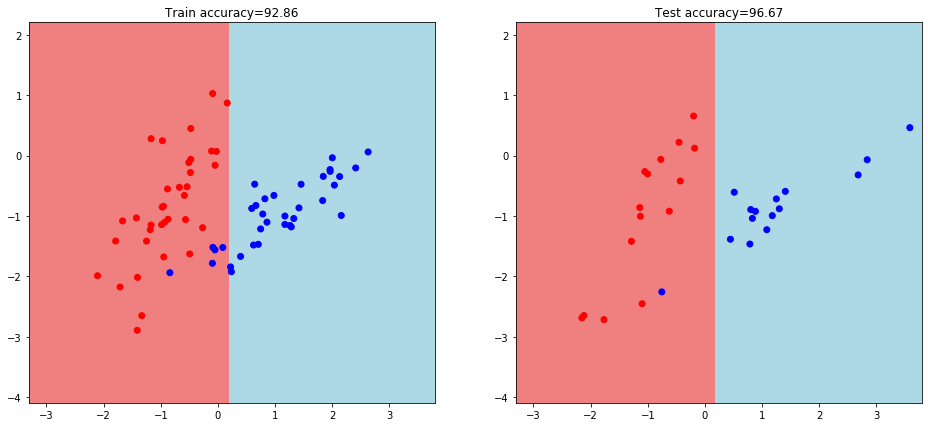

In [22]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

После ограничения __глубины__ дерева до 2 точность модели __снизилась__. тоже самое происходит и с повышением __количества объектов__ в листе